In [1]:
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np
import plotnine as pn
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import os
from skimpy import clean_columns

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)
background_colour = "#F2F2F2"
pn.theme_set(
    pn.theme_classic()
    + pn.theme(
        figure_size=[7, 7/1.618],
        text=pn.element_text(family="monospace"),
        plot_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        panel_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        legend_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
    )
)


%load_ext blackcellmagic
%matplotlib inline

In [2]:
df = (
    pd.read_excel("Publibike Rides.xlsx", parse_dates=["date"])
    .assign(
        duration=lambda x: x["duration"]
        .str.split(" ")
        .apply(lambda r: pd.to_datetime(r[0], format="%H:%M").minute),
        text=lambda x: x["text"]
        .str.removesuffix("| BusinessBike (30'/70)")
        .str.split("→"),
        from_station=lambda x: x["text"].apply(lambda r: r[0].strip()),
        to_station=lambda x: x["text"].apply(lambda r: r[1].strip()),
    )
    .drop("text", axis=1)
)
df

,date,duration,from_station,to_station
0,2024-03-30,21,Wipkingerplatz,Schmiede Wiedikon
1,2024-03-30,25,Kunsthaus,Wipkingerplatz
2,2024-03-30,21,Kreuzplatz,Kunsthaus
3,2024-03-30,21,Bellevue,Kreuzplatz
4,2024-03-30,19,Utoplatz,Bellevue
...,...,...,...,...
295,2023-09-20,2,Schmiede Wiedikon,Weststrasse
296,2023-09-19,20,Milchbuck,Schmiede Wiedikon
297,2023-09-19,16,Schmiede Wiedikon,Milchbuck
298,2023-09-19,5,Comerge,Schmiede Wiedikon


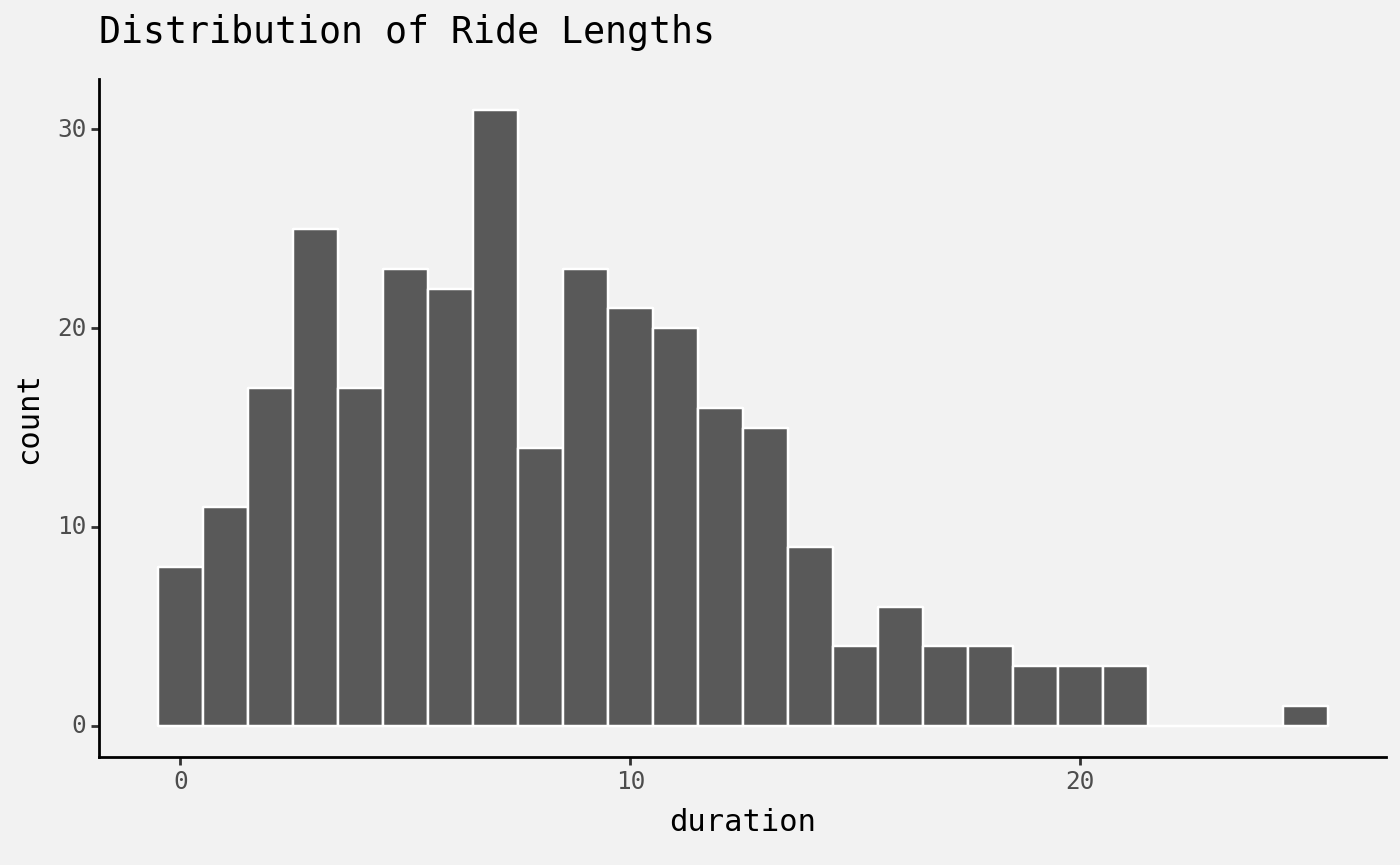

<Figure Size: (700 x 432)>

In [3]:
(
    pn.ggplot(data = df, mapping = pn.aes("duration"))
    + pn.labs(title="Distribution of Ride Lengths")
    + pn.geom_histogram(binwidth = 1, colour="white")
)

### Ride times from and to ETH

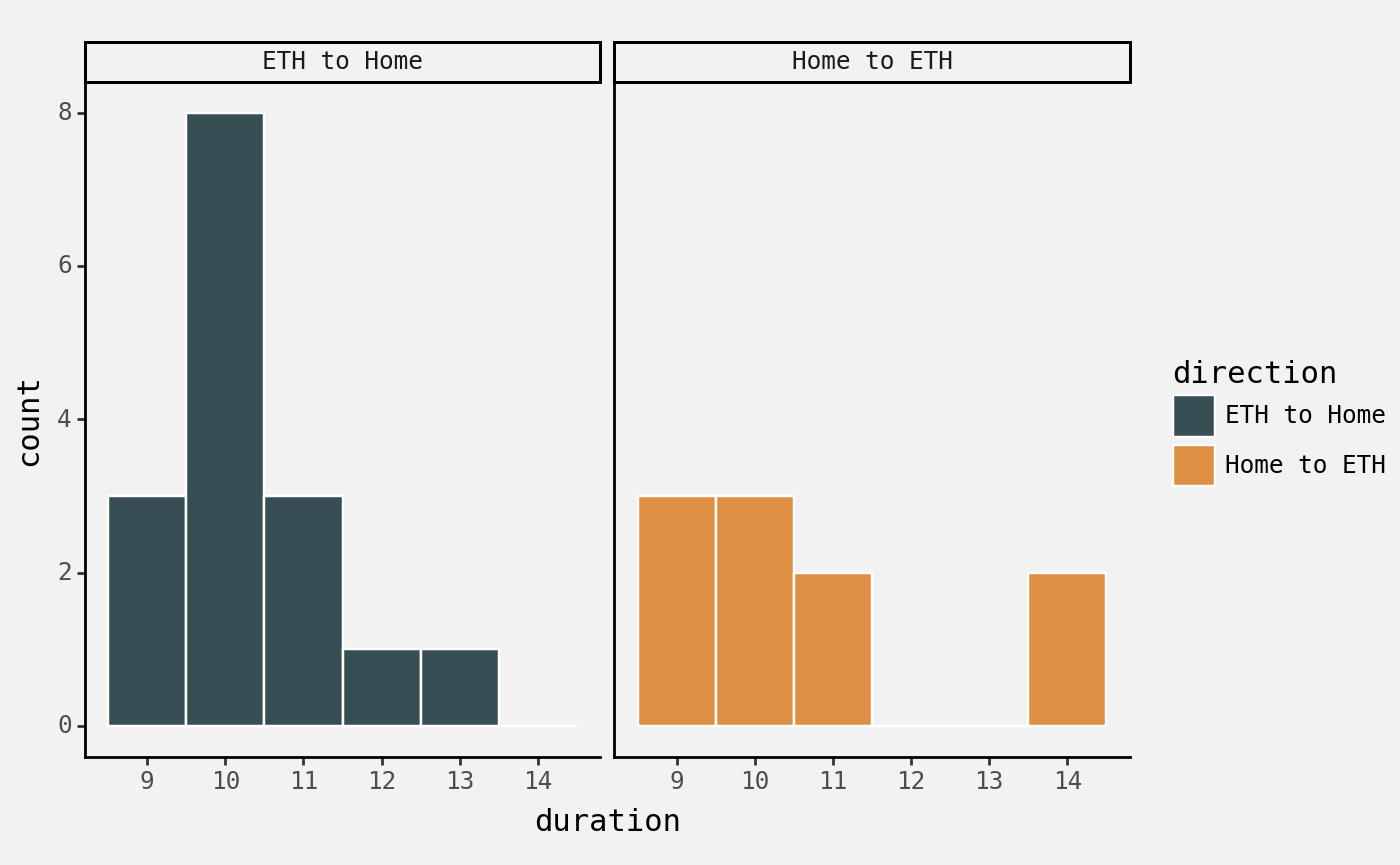

<Figure Size: (700 x 432)>

In [4]:
(
    pn.ggplot(data = (
    df.assign(
        direction=lambda x: np.select(
            condlist=[
                (x.from_station == "Schmiede Wiedikon")
                & (x.to_station == "ETH Zentrum Leonhardstrasse"),
                (x.to_station == "Schmiede Wiedikon")
                & (x.from_station == "ETH Zentrum Leonhardstrasse"),
            ],
            choicelist=[
                "Home to ETH",
                "ETH to Home",
            ],
            default=pd.NA,
        )
    )
    .dropna(subset="direction")
    .reset_index(drop=True)
),
mapping = pn.aes(x="duration", fill="direction"))
+ pn.geom_histogram(binwidth=1, colour="white")
+ pn.facet_wrap("~ direction")
+ pn.scale_fill_manual(values=jama_colour)
+ pn.scale_x_continuous(breaks=range(9, 15, 1))
)

### Time on Publibike by...

- Month
- Week
- Day of Week
- Time of Day

In [38]:
(
    pl.from_pandas(df)
    .group_by("date")
    .agg(pl.sum("duration").alias("daily_minutes"))
    .sort("daily_minutes", descending=True)
    .head()
)

date,daily_minutes
datetime[ns],i64
2024-03-30 00:00:00,134
2024-03-29 00:00:00,74
2023-10-12 00:00:00,56
2023-10-02 00:00:00,52
2023-09-20 00:00:00,51


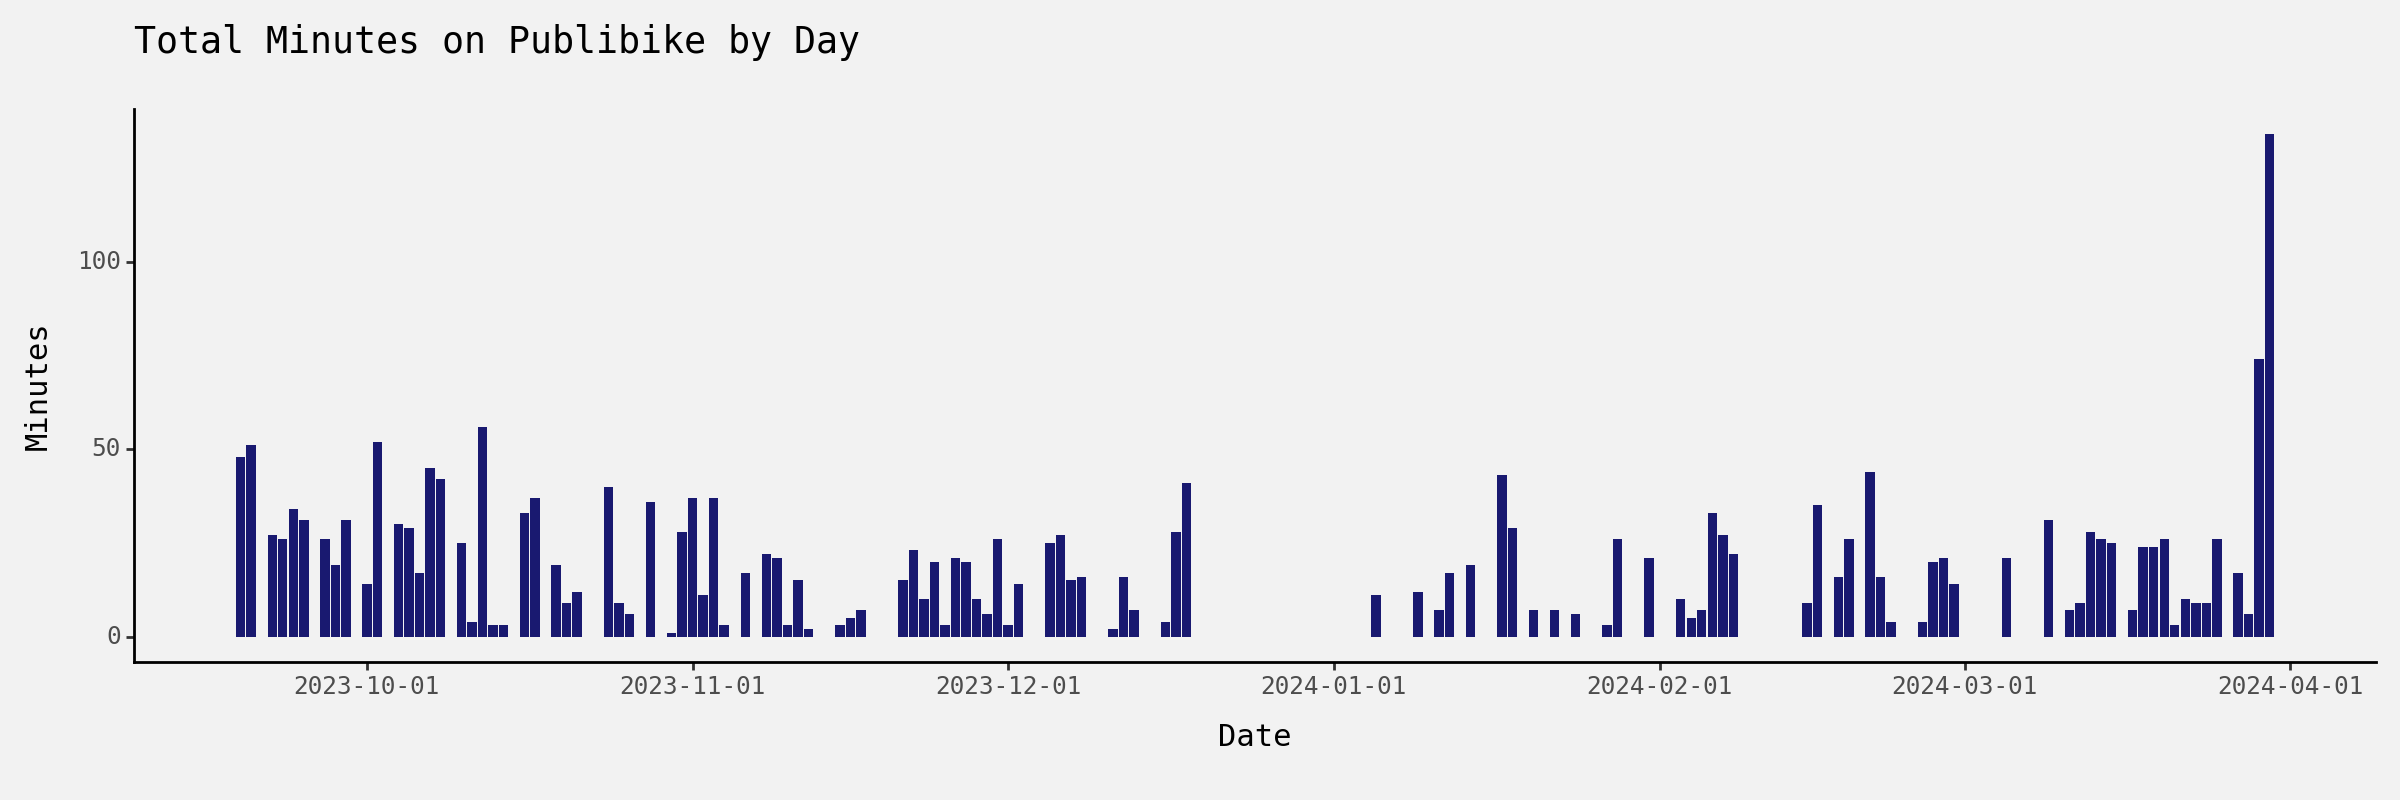

<Figure Size: (1200 x 400)>

In [20]:
(
    pn.ggplot(
        data=(
            (pl.from_pandas(df).group_by("date").agg(pl.sum("duration")).sort("date"))
        ),
        mapping=pn.aes(x="date", y="duration"),
    )
    + pn.geom_col(fill="midnightblue")
    + pn.labs(title="Total Minutes on Publibike by Day", y="Minutes", x="Date")
    + pn.theme(figure_size=[12, 4])
)

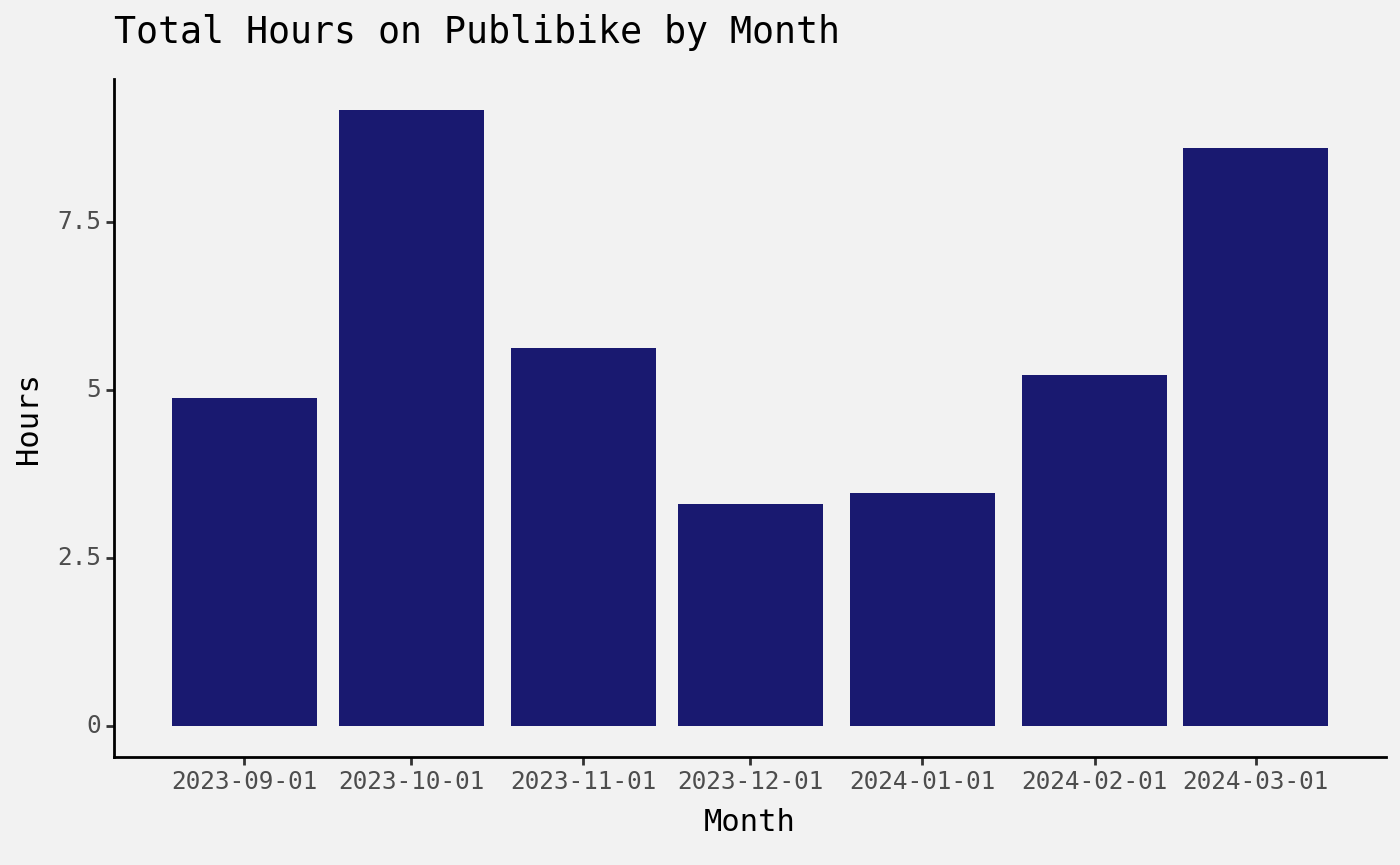

<Figure Size: (700 x 432)>

In [5]:
(
    pn.ggplot(
        data=(
            pl.from_pandas(df)
            .with_columns(pl.col("date").dt.truncate("1mo"))
            .group_by("date")
            .agg(pl.sum("duration"))
            .with_columns(pl.col("duration") / 60)
        ),
        mapping=pn.aes(x="date", y="duration"),
    )
    + pn.geom_col(fill="midnightblue")
    + pn.labs(title="Total Hours on Publibike by Month", y="Hours", x="Month")
)

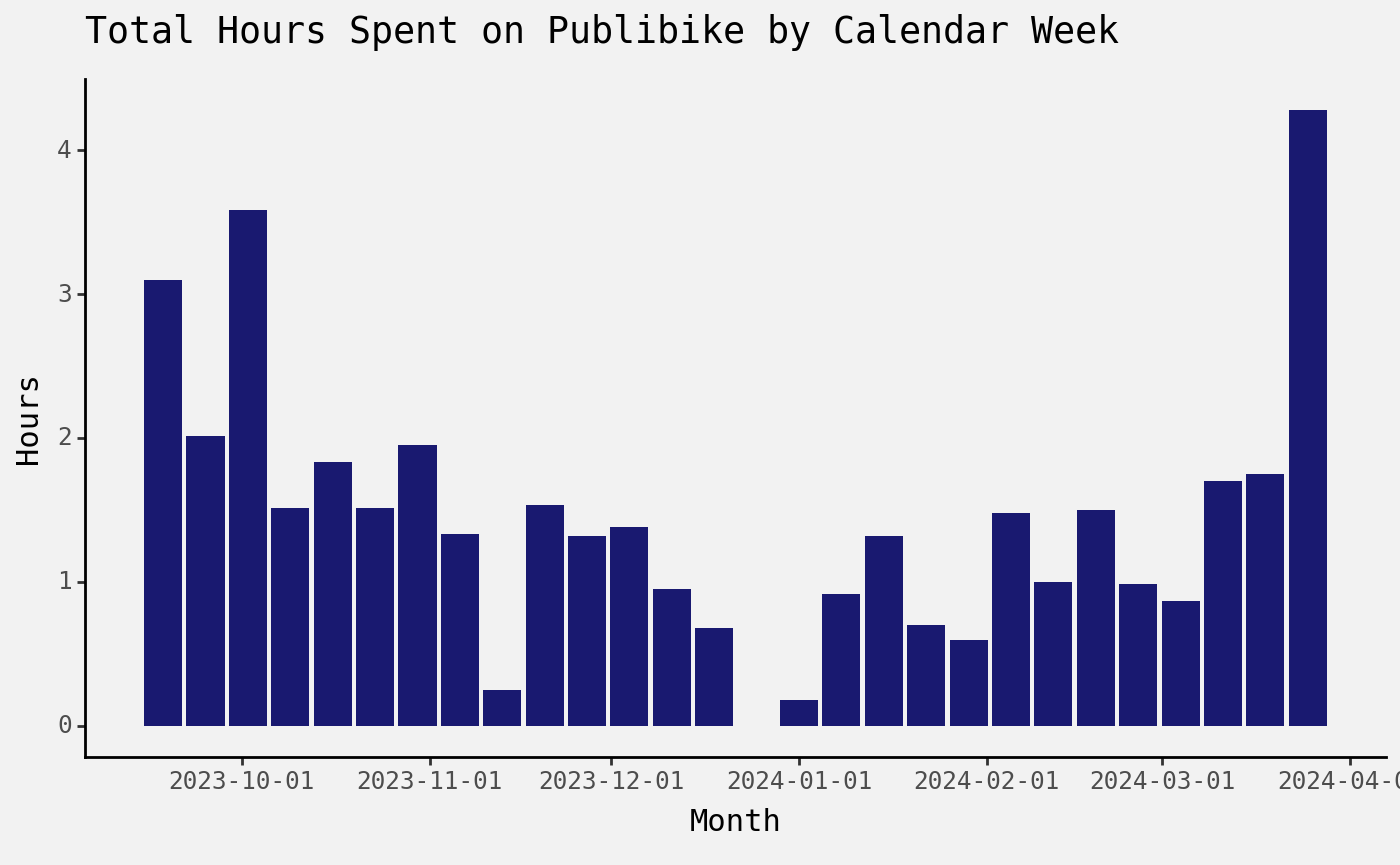

<Figure Size: (700 x 432)>

In [6]:
(
    pn.ggplot(
        data=(
            pl.from_pandas(df)
            .with_columns(pl.col("date").dt.truncate("1w"))
            .group_by("date")
            .agg(pl.sum("duration"))
            .with_columns(pl.col("duration") / 60)
        ),
        mapping=pn.aes(x="date", y="duration"),
    )
    + pn.geom_col(fill="midnightblue")
    + pn.labs(title="Total Hours Spent on Publibike by Calendar Week", y="Hours", x="Month")
    # + pn.scale_x_date(date_breaks="3 weeks", date_labels="%d.%m.%y")
)

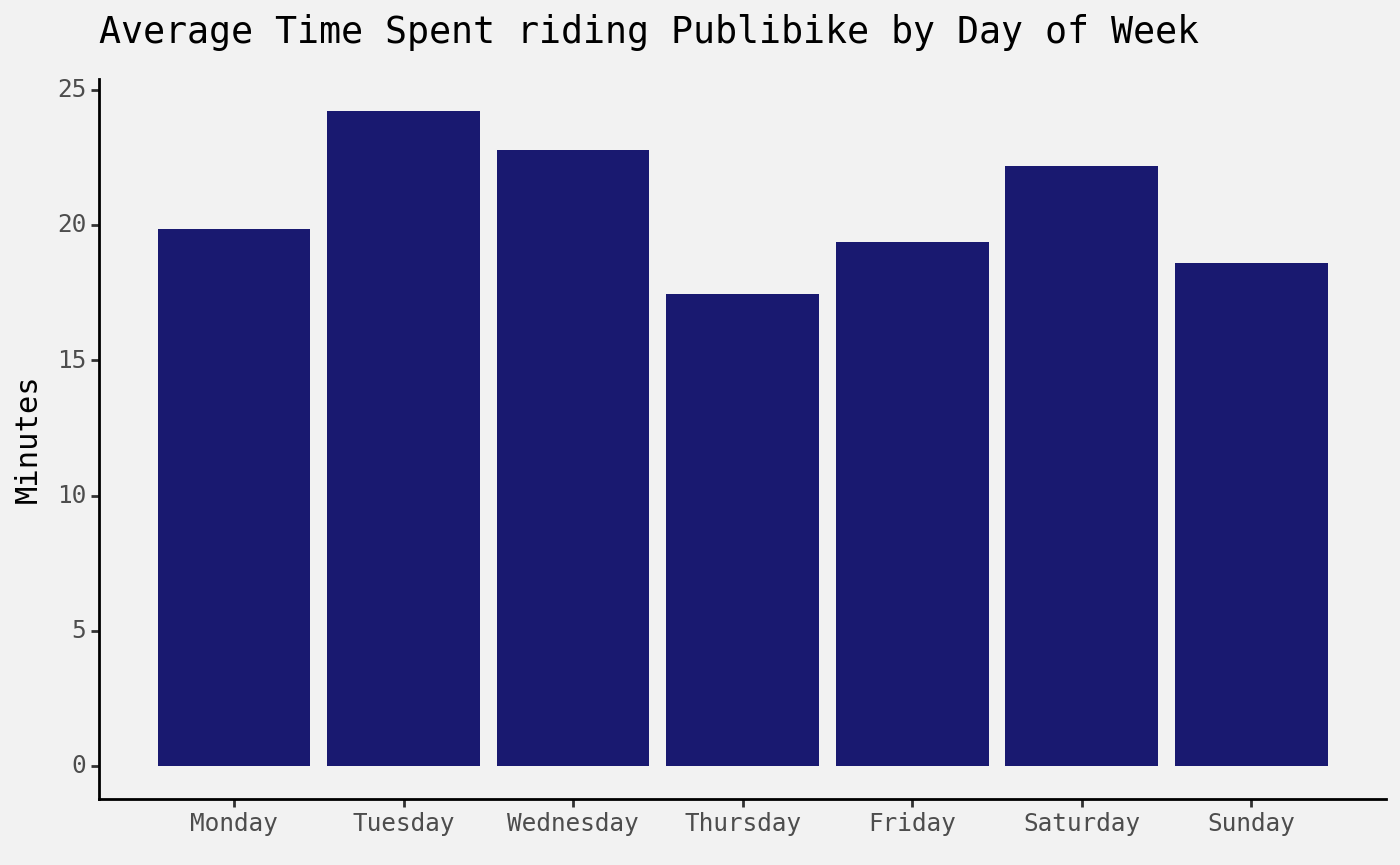

<Figure Size: (700 x 432)>

In [7]:
(
    pn.ggplot(
        data=(
            pl.from_pandas(df)
            .group_by("date")
            .agg(pl.sum("duration"))
            .with_columns(pl.col("date").dt.weekday())
            .group_by("date")
            .agg(pl.mean("duration"))
        ),
        mapping=pn.aes(x="date", y="duration"),
    )
    + pn.geom_col(fill="midnightblue")
    + pn.labs(title="Average Time Spent riding Publibike by Day of Week", y="Minutes", x="Weekday")
    + pn.scale_x_continuous(breaks=[1, 2, 3, 4, 5, 6, 7], labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    + pn.theme(axis_title_x=pn.element_blank())
)

### Costs comparison based on riding profile of the past semester

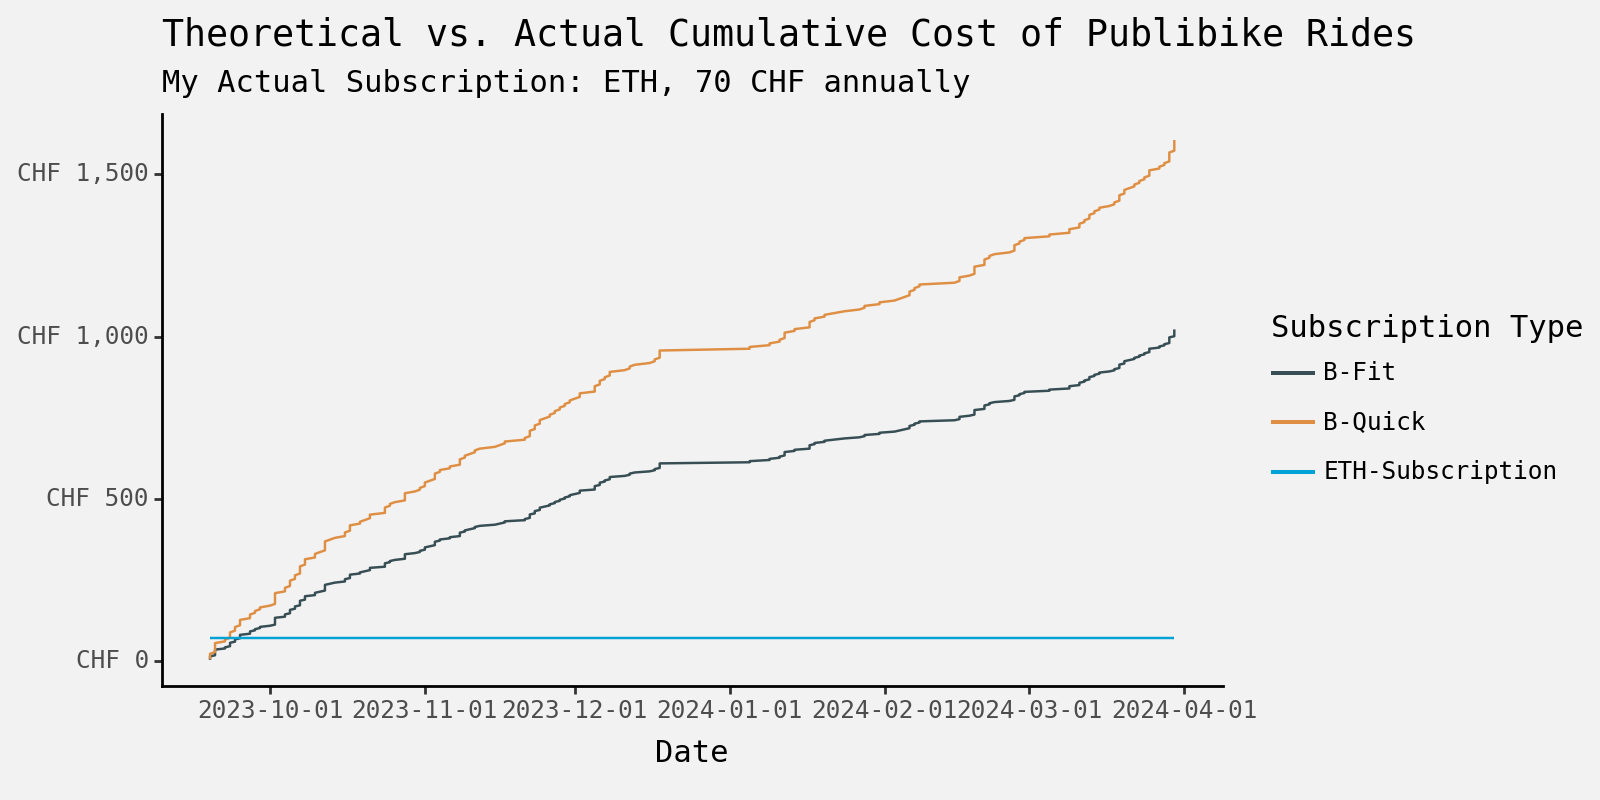

<Figure Size: (800 x 400)>

In [8]:
(
    pn.ggplot(
        data=(
            pl.from_pandas(df)
            .with_columns(
                ((np.ceil(pl.col("duration") / 30)) * 3.5).alias("B-Fit"),
                ((np.ceil(pl.col("duration") / 30)) * 5.5).alias("B-Quick"),
                pl.lit(0).alias("ETH-Subscription"),
            )
            .sort("date")
            .select(["date", "B-Fit", "B-Quick", "ETH-Subscription"])
            .with_columns(cs.numeric().cumsum())
            .with_columns(
                pl.col("ETH-Subscription") + 70,
            )
            .melt("date")
        ),
        mapping=pn.aes(x="date", y="value", colour="variable"),
    )
    + pn.geom_line()
    + pn.labs(
        title="Theoretical vs. Actual Cumulative Cost of Publibike Rides",
        x="Date",
        subtitle="My Actual Subscription: ETH, 70 CHF annually",
        colour="Subscription Type"
    )
    + pn.scale_y_continuous(
        labels=currency_format(prefix="CHF ", digits=0, big_mark=",")
    )
    + pn.scale_colour_manual(values=jama_colour)
    + pn.theme(
        figure_size=[8, 4],
        axis_title_y=pn.element_blank(),

    )
)